In [1]:
#==============================================================================
# Importing libraries
#==============================================================================
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Word2Vec
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
import warnings
from gensim.models import TfidfModel

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#==============================================================================
# Importing data
#==============================================================================
def load_transcripts(file_path):
    data = pd.read_csv(file_path)['transcript']
    return data

transcripts = load_transcripts('datasets/transcripts.csv')

In [3]:
#==============================================================================
# Data comprehension
#==============================================================================
print("Data structure:")
print("Number of TED Talks:", len(transcripts))
print("Sample TED Talk transcript:")
print(transcripts[0])

Data structure:
Number of TED Talks: 2467
Sample TED Talk transcript:
Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here. Just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education — Actually, you're not often at dinner parties, frankly.(Laughter)If you work in education, you're not asked.(Laughter)And you're never asked back, curiously. That's str

In [4]:
#==============================================================================
# Preprocessing: Tokenization, Stopwords removal, Lemmatization
#==============================================================================
stopwords = stopwords.words("english")

def preprocess_text(text):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "ADJ", "VERB", "ADV"]]
    preprocessed_text = " ".join(tokens)
    return preprocessed_text

data_preprocessed = transcripts.apply(preprocess_text)

def preprocess_texts(texts):
    preprocessed_texts = [preprocess_text(text) for text in texts]
    preprocessed_texts = [simple_preprocess(text, deacc=True) for text in preprocessed_texts]
    return preprocessed_texts

data_words = preprocess_texts(data_preprocessed)

In [5]:
#==============================================================================
# Creating dictionary and corpus
#==============================================================================
def create_phrases(texts, min_count=5, threshold=100):
    bigram_phrases = gensim.models.Phrases(texts, min_count=min_count, threshold=threshold)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[texts], threshold=threshold)

    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)

    data_bigrams = [bigram[doc] for doc in texts]
    data_bigrams_trigrams = [trigram[bigram[doc]] for doc in data_bigrams]

    return data_bigrams_trigrams

data_bigrams_trigrams = create_phrases(data_words)

id2word = corpora.Dictionary(data_bigrams_trigrams)
corpus = [id2word.doc2bow(text) for text in data_bigrams_trigrams]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(len(corpus)):
    bow = corpus[i]
    low_value_words = [] 
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [6]:
#==============================================================================
# LDA model: Automated selection of optimal number of clusters
#==============================================================================

#==============================================================================
# start_num_topics = 5
# end_num_topics = 20
# step = 1

# coherence_scores = []
# perplexity_scores = []

# for num_topics in range(start_num_topics, end_num_topics + 1, step):
#     lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
#                                                id2word=id2word,
#                                                num_topics=num_topics,
#                                                random_state=100,
#                                                update_every=1,
#                                                chunksize=100,
#                                                passes=10,
#                                                alpha="auto")
#     coherence_model = CoherenceModel(model=lda_model, texts=data_bigrams_trigrams, dictionary=id2word, coherence='c_v')
#     coherence_score = coherence_model.get_coherence()
#     perplexity_score = lda_model.log_perplexity(corpus)
#     coherence_scores.append(coherence_score)
#     perplexity_scores.append(perplexity_score)

# # Find the index of the maximum coherence score
# optimal_index = np.argmax(coherence_scores)
# optimal_num_topics = start_num_topics + optimal_index * step
# print("Optimal number of topics:", optimal_num_topics) ==> 17
# print("Coherence score:", coherence_scores[optimal_index]) ==> 0.489
# print("Perplexity score:", perplexity_scores[optimal_index]) ==> -8.633

# Took about 14min to run
#==============================================================================

optimal_num_topics = 17
# Train the LDA model with the optimal number of topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=optimal_num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

lda_model.save("models/test_model.model")
new_model = gensim.models.ldamodel.LdaModel.load("models/test_model.model")

In [7]:
#==============================================================================
# Visualizing the topics
#==============================================================================
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\Wissem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.121342  0.417681       1        1  14.380731
16    -0.438270  0.103255       2        1  10.945248
13     0.072429  0.084097       3        1   7.822432
9     -0.295470  0.338565       4        1   7.636109
1     -0.075472  0.412476       5        1   7.200063
3      0.134148 -0.375825       6        1   7.159036
8      0.367006 -0.262710       7        1   6.600820
10     0.437498 -0.023640       8        1   6.135465
7      0.256506  0.281495       9        1   6.117402
2      0.241548 -0.127319      10        1   4.741967
12     0.416100  0.167635      11        1   3.982282
4     -0.280781 -0.000605      12        1   3.768589
0     -0.404524 -0.167448      13        1   3.460423
14    -0.055028 -0.458224      14        1   2.893074
15    -0.080203 -0.229492      15        1   2.582206
11    -0.272911 -0.353415      16        1   2.553484
5     -0.143915  0.193473      17        1   2.020669, topic_info=       Term         Freq        Total Category  logprob  loglift
502   woman  4213.000000  4213.000000  Default  30.0000  30.0000
52    brain  3181.000000  3181.000000  Default  29.0000  29.0000
238    life  2391.000000  2391.000000  Default  28.0000  28.0000
201   human  3117.000000  3117.000000  Default  27.0000  27.0000
567    city  2450.000000  2450.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
697    mile   159.229815   462.792591  Topic17  -4.6589   2.8348
996    hour   169.385222   854.055689  Topic17  -4.5971   2.2839
1539  solar   136.565976   526.730440  Topic17  -4.8125   2.5519
593    cost   129.526359   783.542867  Topic17  -4.8654   2.1018
1524   save   102.987806   531.607962  Topic17  -5.0947   2.2604

[925 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         3  0.445322  ability
0         7  0.052024  ability
0         8  0.045781  ability
0        15  0.455726  ability
1602      2  0.064000     able
...     ...       ...      ...
841       8  0.622099    young
841      10  0.296515    young
1600      2  0.388084     zone
1600      6  0.073339     zone
1600     13  0.534761     zone

[1555 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 17, 14, 10, 2, 4, 9, 11, 8, 3, 13, 5, 1, 15, 16, 12, 6])

ValueError: Only supported for TrueType fonts

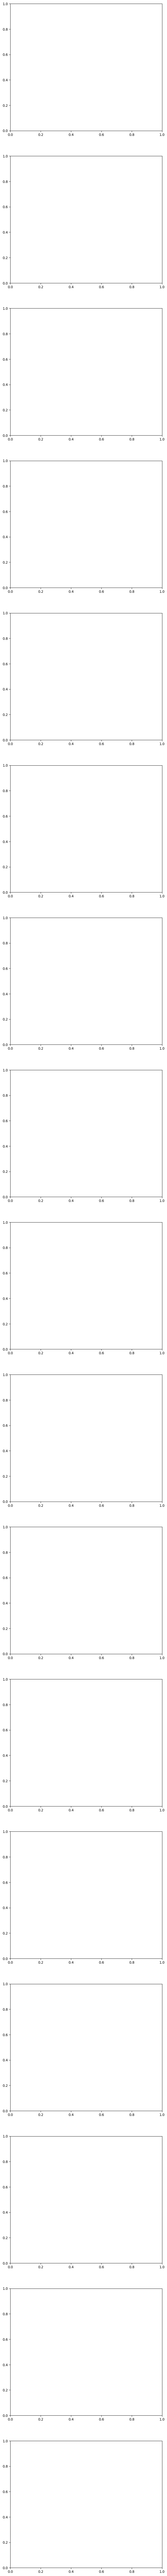

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_word_clouds(lda_model, num_topics):
    fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(8, 8*num_topics))

    for topic in range(num_topics):
        word_weights = lda_model.show_topic(topic, topn=30)
        topic_words = {word: weight for word, weight in word_weights}
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(topic_words)

        axes[topic].imshow(wordcloud, interpolation='bilinear')
        axes[topic].set_title(f'Topic {topic+1}')
        axes[topic].axis('off')

    plt.tight_layout()
    plt.show()

num_topics = 17
visualize_word_clouds(lda_model, num_topics)

In [39]:
#==============================================================================
# Word2Vec model
#==============================================================================
model_w2v = Word2Vec(data_bigrams_trigrams, min_count=5)
model_w2v.save('models/model_w2v.bin')
new_w2v_model = Word2Vec.load('models/model_w2v.bin')

keyword = "climate"
res = new_w2v_model.wv.similar_by_word(keyword, topn=5)
for word, similarity in res:
    print(word, similarity)

global_warming 0.8044320344924927
dramatically 0.7271558046340942
crisis 0.6861761212348938
shift 0.6809927821159363
deforestation 0.6509824991226196


In [12]:
#==============================================================================
# Topic Labeling using Word2Vec
#==============================================================================
def find_similar_words(word, topn=5):
    similar_words = new_w2v_model.wv.similar_by_word(word, topn=topn)
    return [word for word, similarity in similar_words]

def label_topics(topic_keywords, topn=5):
    labeled_topics = []
    for topic in topic_keywords:
        topic_label = []
        for keyword, _ in topic:
            similar_words = find_similar_words(keyword, topn=topn)
            topic_label.extend(similar_words)
        labeled_topics.append(topic_label)
    return labeled_topics

# Get the topic keywords from the LDA model
topic_keywords = [lda_model.show_topic(topic_num, topn=10) for topic_num in range(lda_model.num_topics)]

# Label the topics using Word2Vec
labeled_topics = label_topics(topic_keywords, topn=5)

# Print the labeled topics
for topic_num, topic_label in enumerate(labeled_topics):
    print(f"Topic {topic_num}: {', '.join(topic_label)}")

Topic 0: urban, continent, neighborhood, town, park, building, operate, hardware_software, bridge, engineer, local, organization, partner, rural, support, designer, architect, engineer, architecture, prototype, far_flung, city, slum, anywhere, remote, fare_civilization, dimension, exploration, dimensional, empty, build, bridge, tower, architect, bamboo, town, village, street, slum, suburb, park, apartment, neighborhood, downtown, town, architectural, realm, architect, creation, artistic
Topic 1: solve, issue, solution, challenge, fix, vision, possibility, generation, hope, optimistic, concept, insight, meme, radical, innovation, engineer, team, project, designer, convince, hire, volunteer, training, engineer, manager, tackle, problem, fix, solution, address, global_warming, ocean_acidification, crisis, dramatically, catastrophic, international, housing, rural, community, rebuild, solve, problem, fix, alternative, tackle, huge, deal, small, fan, grand
Topic 2: man, pregnant, gay, rape, 

In [14]:
#==============================================================================
# TESTING THE MODEL
#==============================================================================
def load_main(file_path):
    main = pd.read_csv(file_path)
    return main

main_data = load_main('datasets/ted_main.csv')

In [63]:
#Choose the id of the talk to test the model
id_talk = 1
#Get the transcript of the talk
transcript = transcripts[id_talk]
#What is interesting in the main_data is the column 'tags'
#and the column 'url'
tags = main_data.iloc[id_talk]['tags']
url = main_data.iloc[id_talk]['url']

print("Dataset information: ")
print(f"This ted talk is about {tags}")
print(f"Here is the link to the talk: {url}")

Dataset information: 
This ted talk is about ['alternative energy', 'cars', 'climate change', 'culture', 'environment', 'global issues', 'science', 'sustainability', 'technology']
Here is the link to the talk: https://www.ted.com/talks/al_gore_on_averting_climate_crisis



In [64]:
test_doc = corpus[id_talk]
vector = new_model[test_doc]

def sort_by_value(sub_li):
    sub_li.sort(key=lambda x: x[1])
    return sub_li[::-1]

new_vector = sort_by_value(vector)
new_vector = [item for item in new_vector if item[1] > 0.1]

print("Model prediction: ")
print(f"This Ted Talk belongs to topic {new_vector[0][0]} with a relevance score of {new_vector[0][1]}")
print(f"Topic keywords: {labeled_topics[new_vector[0][0]]}")

Model prediction: 
This Ted Talk belongs to topic 1 with a relevance score of 0.4293936789035797
Topic keywords: ['solve', 'issue', 'solution', 'challenge', 'fix', 'vision', 'possibility', 'generation', 'hope', 'optimistic', 'concept', 'insight', 'meme', 'radical', 'innovation', 'engineer', 'team', 'project', 'designer', 'convince', 'hire', 'volunteer', 'training', 'engineer', 'manager', 'tackle', 'problem', 'fix', 'solution', 'address', 'global_warming', 'ocean_acidification', 'crisis', 'dramatically', 'catastrophic', 'international', 'housing', 'rural', 'community', 'rebuild', 'solve', 'problem', 'fix', 'alternative', 'tackle', 'huge', 'deal', 'small', 'fan', 'grand']
